In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

# print('# File sizes')
# for f in os.listdir('../input'):
#     if 'zip' not in f:
#         print(f.ljust(30) + str(round(os.path.getsize('data/' + f) / 1000000, 2)) + 'MB')

## Dataset Split

We split the data into a train set and a test set.

In [2]:
df = pd.read_csv('data/train.csv')
df_test = df.sample(frac=0.3)
df_train = df[~df.index.isin(df_test.index)]
df = df.reset_index()
df_test = df_test.reset_index()
df_test = df_test.drop(['index','id'],axis=1)
df_test.insert(0,'test_id',df_test.index)
df_test.head(5)

,test_id,qid1,qid2,question1,question2,is_duplicate
0,0,119839,119840,"What's the point of living, when eventually we...",What is the point of living if we are going to...,1
1,1,150434,150435,What is the best way to learn about the conste...,What is the best way to learn the constellations?,1
2,2,11321,16463,How do l improve my communication skills?,How do I improve my communication skills in on...,1
3,3,373538,373539,Why do people often link homosexuality with AIDS?,Would there be no AIDS if there were no homose...,0
4,4,145668,16990,Why do some people hate romantic relationships?,Why do some people dislike Islam?,0


In [3]:
df_train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
10,10,21,22,Method to find separation of slits using fresn...,What are some of the things technicians can te...,0


In [4]:
if len(df) == len(df_test)+len(df_train):
    print('True.')
len(df_test)/len(df)

True.


0.3

In [5]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)

# Initial Feature Analysis

To find the relation between word-share and is_duplicate feature.

Text(0.5, 0, 'word_match_share')

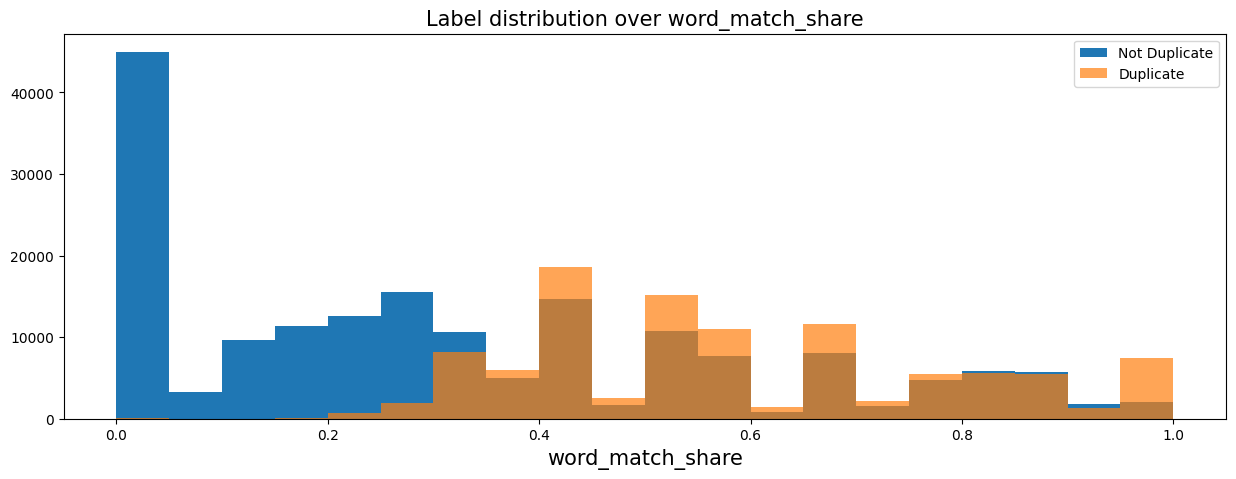

In [6]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

Here we can see that this feature has quite a lot of predictive power, as it is good at separating the duplicate questions from the non-duplicate ones. Interestingly, it seems very good at identifying questions which are definitely different, but is not so great at finding questions which are definitely duplicates.

## TF-IDF

In [7]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [8]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 3.6616221718545752e-06), ('what', 4.393711719786641e-06), ('is', 5.0505815744683e-06), ('how', 6.130681609181308e-06), ('i', 6.292513796336498e-06), ('a', 6.359502686889885e-06), ('to', 6.539666346223016e-06), ('in', 6.844439577287412e-06), ('of', 8.24565454005739e-06), ('do', 8.457517887650332e-06)]

Least common words and weights: 


[('geologist?', 9.998000399920016e-05),
 ('fairness?', 9.998000399920016e-05),
 ('surathkal?', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('gonulcelen', 9.998000399920016e-05),
 ('"1984"', 9.998000399920016e-05),
 ('jaish-e-mohammad', 9.998000399920016e-05),
 ('(jem)', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05)]

In [9]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

/var/folders/ql/fnvk6v291nxg7rmlwmh_m7m80000gn/T/ipykernel_19717/830548937.py:17: RuntimeWarning: invalid value encountered in scalar divide
  R = np.sum(shared_weights) / np.sum(total_weights)


Text(0.5, 0, 'word_match_share')

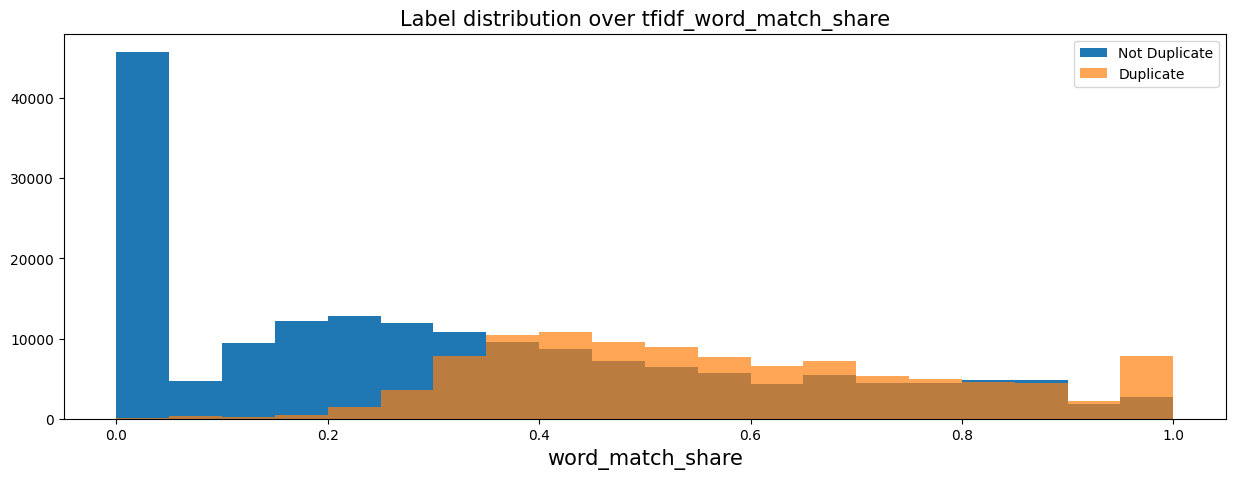

In [10]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

## Data Preparation

In [11]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1)

y_train = df_train['is_duplicate'].values

/var/folders/ql/fnvk6v291nxg7rmlwmh_m7m80000gn/T/ipykernel_19717/830548937.py:17: RuntimeWarning: invalid value encountered in scalar divide
  R = np.sum(shared_weights) / np.sum(total_weights)


In [12]:
# Finally, we split some of the data off for validation
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

## XGBoost

Now we can finally run XGBoost on our data, in order to see the score on the leaderboard!

In [13]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
results = {}
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10, evals_result=results)

[0]	train-logloss:0.68626	valid-logloss:0.68626


/Users/panqiyang/mambaforge/envs/dl-mps/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	train-logloss:0.63002	valid-logloss:0.62999
[20]	train-logloss:0.59024	valid-logloss:0.59021
[30]	train-logloss:0.56114	valid-logloss:0.56110
[40]	train-logloss:0.53934	valid-logloss:0.53929
[50]	train-logloss:0.52276	valid-logloss:0.52270
[60]	train-logloss:0.51000	valid-logloss:0.50995
[70]	train-logloss:0.50011	valid-logloss:0.50007
[80]	train-logloss:0.49242	valid-logloss:0.49239
[90]	train-logloss:0.48637	valid-logloss:0.48632
[100]	train-logloss:0.48153	valid-logloss:0.48148
[110]	train-logloss:0.47767	valid-logloss:0.47762
[120]	train-logloss:0.47461	valid-logloss:0.47455
[130]	train-logloss:0.47218	valid-logloss:0.47212
[140]	train-logloss:0.47020	valid-logloss:0.47015
[150]	train-logloss:0.46864	valid-logloss:0.46859
[160]	train-logloss:0.46733	valid-logloss:0.46731
[170]	train-logloss:0.46627	valid-logloss:0.46628
[180]	train-logloss:0.46541	valid-logloss:0.46544
[190]	train-logloss:0.46469	valid-logloss:0.46474
[200]	train-logloss:0.46405	valid-logloss:0.46413
[210]	tra

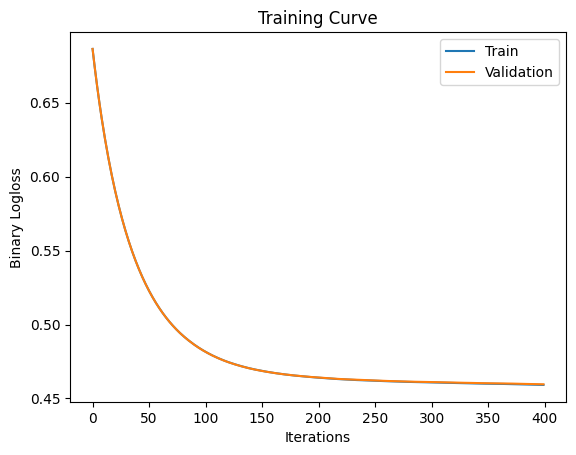

In [14]:
train_loss = results['train']['logloss']
val_loss = results['valid']['logloss']

# loss function curve
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.xlabel('Iterations')
plt.ylabel('Binary Logloss')
plt.title('Training Curve')
plt.legend()
plt.show()

In [15]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

threshold = 0.5

def pred_dup(row):
    if row['pred']<=threshold:
        return 0
    else:
        return 1

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['pred'] = p_test
sub['pred_duplicate'] = sub.apply(pred_dup, axis=1)
sub['is_duplicate'] = df_test['is_duplicate']
# sub.to_csv('simple_xgb.csv', index=False)
sub.head(5)

,test_id,pred,pred_duplicate,is_duplicate
0,0,0.536090,1,1
1,1,0.781678,1,1
2,2,0.609988,1,1
3,3,0.001772,0,0
4,4,0.196828,0,0


In [16]:
def hit(row):
    if row['pred_duplicate']==row['is_duplicate']:
        return 1
    else:
        return 0
    
sub['correct'] = sub.apply(hit,axis=1)
acc = sub['correct'].sum()/len(sub)
acc

0.734860290055818

In [17]:
prec = len(sub.loc[(sub['is_duplicate']==1) & (sub['pred_duplicate']==1)])/len(sub.loc[sub['pred_duplicate']==1])
prec

0.5948001659521505

In [18]:
# sub[sub['is_duplicate']==1 & sub['pred_duplicate']==1]
recall = len(sub.loc[(sub['is_duplicate']==1) & (sub['pred_duplicate']==1)])/len(sub.loc[sub['is_duplicate']==1])
recall

0.8699238150886577